In [1]:
import numpy as np
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter, ParameterVector

In [2]:
circ = QuantumCircuit(2, 2)
vector = [np.pi/2, np.pi/2]
circ.h([0, 1])
circ.initialize(vector, qubits=[0], normalize=True)
theta = Parameter("theta")
circ.ry(theta, 1)
circ.cx(0, 1)
circ.draw()

┌───┐┌─────────────────────────────┐     
q_0: ┤ H ├┤ Initialize(0.70711,0.70711) ├──■──
     ├───┤└────────┬───────────┬────────┘┌─┴─┐
q_1: ┤ H ├─────────┤ Ry(theta) ├─────────┤ X ├
     └───┘         └───────────┘         └───┘
c: 2/═════════════════════════════════════════

In [3]:
meas = QuantumCircuit(2, 2)
meas.measure(range(2), range(2))
# meas.draw()
sampler_circ = circ.compose(meas, qubits=[0, 1], clbits=[0, 1], inplace=False)
sampler_circ.draw()

┌───┐┌─────────────────────────────┐     ┌─┐   
q_0: ┤ H ├┤ Initialize(0.70711,0.70711) ├──■──┤M├───
     ├───┤└────────┬───────────┬────────┘┌─┴─┐└╥┘┌─┐
q_1: ┤ H ├─────────┤ Ry(theta) ├─────────┤ X ├─╫─┤M├
     └───┘         └───────────┘         └───┘ ║ └╥┘
c: 2/══════════════════════════════════════════╩══╩═
                                               0  1

In [32]:
# Simple circuit
simple_circ = QuantumCircuit(2, 2)
simple_circ.h([0, 1])
theta = Parameter("theta")
simple_circ.ry(theta, 1)
simple_circ.cx(0, 1)
simple_circ.draw()

┌───┐                  
q_0: ┤ H ├───────────────■──
     ├───┤┌───────────┐┌─┴─┐
q_1: ┤ H ├┤ Ry(theta) ├┤ X ├
     └───┘└───────────┘└───┘
c: 2/═══════════════════════

In [34]:
sampler_simple_circ = simple_circ.compose(meas, qubits=[0, 1], clbits=[0, 1], inplace=False)
sampler_simple_circ.draw()

┌───┐                  ┌─┐   
q_0: ┤ H ├───────────────■──┤M├───
     ├───┤┌───────────┐┌─┴─┐└╥┘┌─┐
q_1: ┤ H ├┤ Ry(theta) ├┤ X ├─╫─┤M├
     └───┘└───────────┘└───┘ ║ └╥┘
c: 2/════════════════════════╩══╩═
                             0  1

In [84]:
# IBM Provider
from qiskit_ibm_provider import IBMProvider

# Fake backend
from qiskit.providers.fake_provider import FakeMumbaiV2

In [85]:
provider = IBMProvider()
# provider.backends()
backend = provider.get_backend("ibmq_qasm_simulator")
fake_backend = FakeMumbaiV2()

In [91]:
# Transpilation
from qiskit import transpile

# transpiled_circ = transpile(sampler_simple_circ, backend)
transpiled_circ = transpile(sampler_simple_circ, fake_backend)
transpiled_circ.assign_parameters({theta: np.pi/2}, inplace=True)
# transpiled_circ.draw()

In [101]:
# Ideal
job = backend.run(transpiled_circ)
# Noisy 
noisy_job = fake_backend.run(transpiled_circ)

result = job.result()
noisy_result = noisy_job.result()

counts = result.get_counts()
noisy_counts = noisy_result.get_counts()
print(counts, noisy_counts)

{'01': 1983, '10': 2017} {'01': 468, '11': 26, '00': 35, '10': 495}


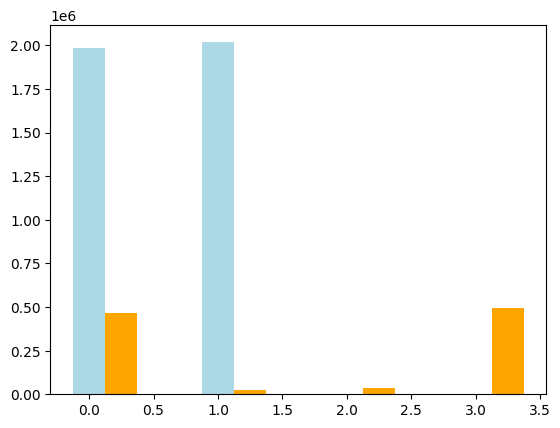

In [102]:
import matplotlib.pyplot as plt

# Compare Results
x = range(4)

# Ideal
for index, (k, v) in enumerate(counts.items()):
    plt.bar(x[index] + 0, v*1000, color="lightblue", width=0.25)

# Noisy
for index, (k, v) in enumerate(noisy_counts.items()):
    plt.bar(x[index] + 0.25, v*1000, color="orange", width=0.25)

# # Mitigated
# for k, v in mitigated_quasi_dists[0].items():
#     plt.bar(x[k] + 0.5, v*1000, color="pink", width=0.25)

plt.show()

In [103]:
# Primitives
from qiskit.primitives import Sampler, Estimator, BackendSampler, BackendEstimator

In [110]:
# Observables
from qiskit.quantum_info import SparsePauliOp

observables = SparsePauliOp(["ZZ"])

In [105]:
# Sampler
sampler = Sampler()
job = sampler.run(sampler_circ, parameter_values=[np.pi/2], shots=1000)
results = job.result()
print(results)

SamplerResult(quasi_dists=[{1: 0.487, 2: 0.513}], metadata=[{'shots': 1000}])


In [115]:
# BackendSampler
# Very basic, cannot handle initialize circuit instruction.
backend_sampler = BackendSampler(backend=fake_backend)
job = backend_sampler.run(sampler_simple_circ, parameter_values=[np.pi/2], shots=1000)
results = job.result()
print(results)

SamplerResult(quasi_dists=[{0: 0.033, 3: 0.024, 2: 0.461, 1: 0.482}], metadata=[{'shots': 1000}])


In [111]:
# Estimator
estimator = Estimator()
job = estimator.run(circ, parameter_values=[np.pi/2], observables=observables, shots=1000)
results = job.result()
print(results)

EstimatorResult(values=array([-1.]), metadata=[{'variance': 3.3306690738754696e-16, 'shots': 1000}])


In [114]:
# BackendEstimator
# Again, very basic, cannot handle initialize circuit instruction
backend_estimator = BackendEstimator(backend=backend)
job = backend_estimator.run(simple_circ, parameter_values=[np.pi/2], observables=observables, shots=1000)
results = job.result()
print(results)

EstimatorResult(values=array([-1.]), metadata=[{'variance': 0.0, 'shots': 1000}])


In [ ]:
# Noise Models and Error mitigation
